In [4]:
#| echo: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
import seaborn as sns
import shapely as sh
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

comm_areas_df = pd.read_csv('./datasets/CommAreas_20241114.csv')
my_chi_df = pd.read_csv('./datasets/My_CHI._My_Future._Programs_20241113.csv')
census_data_df = pd.read_csv('./datasets/Census_Data.csv')
from tabulate import tabulate



## Problem statement 

This study explores how socioeconomic, environmental, and logistical factors shape the accessibility and equity of community programs. It investigates the influence of community socioeconomic status (SES) on program availability, the evolution of equity-focused features (such as scholarships, free food, and transportation) in low-SES areas, the effect of climate and seasonal timing on program types and costs for various age groups, and how program location (online vs. in-person) and accessibility via public transportation impact support for participant access. We aim to gain insight on program distribution across the Chicago community by identifying where, when, and what kinds, of programs are currently offered for different communities. This would aid the My CHI. My Future. team collaborate more effectively with partners, prioritize community needs, and work toward their mission of connecting all Chicago youth with meaningful out-of-school opportunities. It is imperative we ensure a more equitable and accessible range of opportunities for youth across the city.


## Data sources


[My Chi. My Future](https://data.cityofchicago.org/Events/My-CHI-My-Future-Programs/w22p-bfyb/about_data)
This dataset provides comprehensive information on all programs under the My Chi. My Future initiative, including key details such as accessibility features, start/end dates, and location. By analyzing various aspects of this dataset, we aim to uncover trends and correlations that address the primary research questions. The version of this dataset used for analysis was downloaded on November 13, 2024.


[Chicago Temperature](https://www.weather.gov/wrh/climate?wfo=lot)
This dataset contains monthly average temperature records for Chicago from 2000 to 2024. It will be used to evaluate the influence of temperature and seasonality on the types and pricing of community programs, particularly focusing on how weather conditions affect program offerings across different age groups (Research Question 3).


[Chicago Census Data](https://data.cityofchicago.org/Health-Human-Services/Per-Capita-Income/r6ad-wvtk)
The hardship index data provides insights into socioeconomic conditions across various Chicago communities, which is crucial for analyzing the relationship between community socioeconomic status and program accessibility (Research Questions 1 and 2).


[CTA Info](https://www.transitchicago.com/data/)
This dataset includes extensive information on Chicago Transit Authority station and bus stop locations. It will be utilized to examine the proximity of community programs to public transportation, helping to understand the effects of accessibility on program participation and the support provided (Research Question 4).

[Chicago Boundaries](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)
The boundaries dataset provides geographical data on Chicago's neighborhoods, which allows for categorizing the different programs in the My Chi. My Future dataset by community area. This categorization is essential for analysis related to community socioeconomic factors and their impact on accessibility (Research Questions 1 and 2).



## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

In [6]:


# Filter to only the relevant columns used in the analysis
relevant_columns = ['COMMUNITY AREA NAME', 'HARDSHIP INDEX']
census_data_filtered = census_data_df[relevant_columns]

# Function to summarize categorical variables
def summarize_categorical(data, column):
    summary = {}
    summary['Variable'] = column
    summary['Type'] = 'Categorical'
    summary['Missing Values'] = data[column].isna().sum()
    summary['Unique Values'] = data[column].nunique()
    if summary['Unique Values'] > 5:  # Include top 5 levels if too many
        summary['Top Levels'] = data[column].value_counts().nlargest(5).to_dict()
    else:  # Include all levels if few
        summary['Top Levels'] = data[column].value_counts().to_dict()
    return summary

# Function to summarize continuous variables
def summarize_continuous(data, column):
    summary = {}
    summary['Variable'] = column
    summary['Type'] = 'Continuous'
    summary['Missing Values'] = data[column].isna().sum()
    summary['Mean'] = data[column].mean()
    summary['Standard Deviation'] = data[column].std()
    summary['Min'] = data[column].min()
    summary['Max'] = data[column].max()
    summary['Median'] = data[column].median()
    return summary

# Summarize relevant variables
summaries = []
for column in census_data_filtered.columns:
    if census_data_filtered[column].dtype == 'object' or census_data_filtered[column].nunique() < 20:  # Treat as categorical
        summaries.append(summarize_categorical(census_data_filtered, column))
    else:  # Treat as continuous
        summaries.append(summarize_continuous(census_data_filtered, column))

# Convert summaries into a DataFrame for tabular display
summary_df = pd.DataFrame(summaries)

print(tabulate(summary_df, headers='keys', tablefmt='grid'))


+----+---------------------+-------------+------------------+-----------------+--------------------------------------------------------------------------------------------+----------+----------------------+-------+-------+----------+
|    | Variable            | Type        |   Missing Values |   Unique Values | Top Levels                                                                                 |     Mean |   Standard Deviation |   Min |   Max |   Median |
+====+=====================+=============+==================+=================+============================================================================================+==========+======================+=======+=======+==========+
|  0 | COMMUNITY AREA NAME | Categorical |                0 |              78 | {'Rogers Park': 1, 'Pullman': 1, 'Archer Heights': 1, 'Garfield Ridge': 1, 'Hegewisch': 1} | nan      |             nan      |   nan |   nan |      nan |
+----+---------------------+-------------+------------------+---

Data Imputation

After inspecting the "Geographic Cluster Name" column in the MCMF dataset, we found that there are 121,359 missing values for in-person programs. Since both analysis 1 and 2 relies heavily on information about the neighborhood programs belong to, we decided to use the geographic information in Community Boundaries dataset and latitude longtitude information in the MCMF dataset to map programs into respective neighborhoods. We accomplished this through two different methods. Our first method was used in Analysis 1 and our second was used in Analysis 2. 

Our first method employs geospatial methods to impute missing values in the 'Geographic Cluster Name' column by utilizing latitude and longitude coordinates in the original dataset along with geographic community boundaries from a secondary MCMF dataset. To prepare for this, the community areas dataset was converted into a GeoDataFrame by interpreting the 'the_geom' column, which contains geographic boundary data. This allowed the polygons representing community areas to be used for spatial operations. Next, the program dataset (my_chi_df) was filtered to remove rows with missing latitude or longitude values, as these coordinates are essential for the imputation process. Valid latitude and longitude values were then converted into geometric Point objects, and the filtered data was transformed into a GeoDataFrame to enable spatial operations. Before conducting the spatial join, the 'Geographic Cluster Name' and 'COMMUNITY' columns in the datasets were standardized by converting text to uppercase and stripping whitespace to ensure consistency in comparisons. A spatial join was then performed between the program points and the community area polygons. This operation assigned each point to the community area polygon in which it falls. For programs with multiple locations, the most common community name (mode) for each program was determined by grouping the data by 'Program Name'. This mapping of program names to community names was then applied back to the original dataset to fill in missing values in the 'Geographic Cluster Name' column.

In our second method, we compared the neighborhood names in the MCMF dataset with neighborhood names in the Community Boundaries dataset to see if there are any difference. We found that aside from neighborhood names, some programs in the MCMF dataset used unstandardized names such as "Far South Equity Zone" and "Back of the Yards", which also need to be mapped. After extracting programs that has both longitude and latittude information and don't have a geographic cluster name or its geographic cluster name is unstandardized, we turned longitude lattitude information into shapely library point format. We also turned the multipolygon in Community Boundaries dataset into shapely format. Next, for each longitude-latitude pair, we checked if it is in any of the multipolygon that represents a neighborhood. After mapping, we reviewed the neighborhoods assigned to programs with unstandardized names. This step was necessary because some programs with unstandardized names lack latitude-longitude data, and we wanted to map them to the same neighborhoods as others with the same unstandardized name. However, upon review, we found that many unstandardized names, such as equity zones, were mapped to different neighborhood names. To avoid inconsistencies—where some equity zones are converted into neighborhood names while others remain unchanged— we decided to create a new column, "Neighborhood," dedicated exclusively to neighborhood names. Programs in equity zones that could not be mapped to a specific neighborhood will be marked as "NA" in this column.

## Exploratory Data Analysis

For each analysis:

What did you do exactly? How did you solve the problem? Why did you think it would be successful? 

What problems did you anticipate? What problems did you encounter? Did the very first thing you tried work? 

Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

### Analysis: How Does Community Socioeconomic Status Relate to the Accessibility of In-Person Programs?
*By \<Gina Valdivia>*

The goal of this analysis is to understand the relationship between community socioeconomic status (SES) and the accessibility of in-person programs in different neighborhoods. By analyzing the availability, affordability, and accessibility features of these programs, we aim to identify inequalities across different SES groups. The SES categories are determined using the Hardship Index and are divided into three bins: Low-SES, Mid-SES, and High-SES. Since the hardship index is a multidimensional measure of a community's socioeconomic conditions, we decided it was an effective way to assess a community's wellbeing. Communities with higher hardship index scores have worse economic and social conditions than communities with lower scores. Our analysis addresses how the density of programs vary across SES levels, whether there are differences in program types or costs among SES categories, and whether low-SES communities are receiving support features like scholarships, free transportation, or free food. We answer these questions using various visualizations that capture program density, availability of support features, and overall accessibility. We created bar plots and scatter plots to visualize program attributes across SES levels. We also used a line of best fit to understand the correlation between hardship and program count.

In regards to data preparation, we first filtered out the dataset to include only face-to-face programs, as we wanted to assess the accessibility of in-person programs since it was based on the location of the program. We also created Socioeconomic Status (SES) bins using the Hardship Index to categorize neighborhoods into High-SES, Mid-SES, and Low-SES using data from Chicago Census. Finally, merged program data with socioeconomic data to obtain the full set of information for each community, ensuring that each program had corresponding socioeconomic metrics.

We encountered a lot of missing data in the Geographic Cluster Name column from the My Chi. My Future data, making it difficult to categorize them geographically to merge with socioeconomic information of the region. We resolved this using geospatial imputation with Chicago Boundaries data. We utilized GeoPandas to do a spatial join with the latitude and longitude coordinates to match them with the appropriate community area polygon. We also encountered issues with the geographic cluster names being inconsistent, making it difficult to merge, so we converted them to uppercase and removed any extra whitespace. 

To assess the impact of community hardship on the number of available programs, we created a scatter plot with a line of best fit between Program Count and the Hardship Index. The Pearson correlation coefficient (r) was -0.240 and P-value was 3.928e-02 for this graph. This p value is under 0.05, and thus indicates that the correlation was statistically significant.


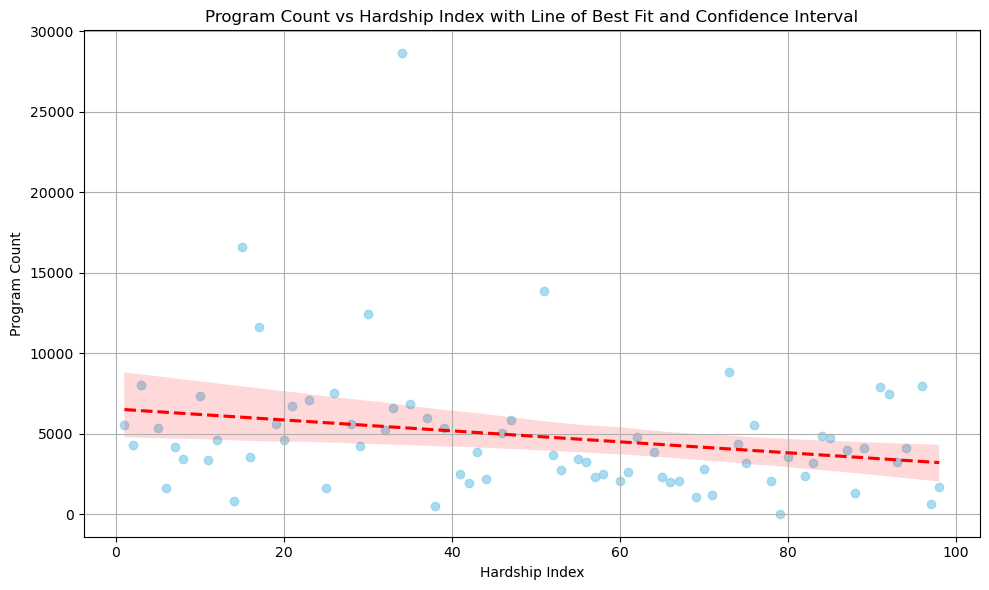

In [ ]:
#| echo: false
# Plotting Hardship Index vs Program Count with a line of best fit including confidence interval
plt.figure(figsize=(10, 6))
sns.regplot(
    data=density_income_df,
    x='HARDSHIP INDEX',
    y='Hardship Program Count',
    ci=95,  # Confidence interval level, default is 95%
    scatter_kws={'color': 'skyblue', 'alpha': 0.7},
    line_kws={'color': 'red', 'linestyle': '--'}
)

plt.xlabel('Hardship Index')
plt.ylabel('Program Count')
plt.title('Program Count vs Hardship Index with Line of Best Fit and Confidence Interval')
plt.grid(True)
plt.tight_layout()
plt.show()


There are a few outliers, which influence the slope of the line of best fit, but the narrow confidence interval suggests that the model is able to explain the data quite precisely for the majority of the points and the outliers' influence is limited. We notice that there is a negative correlation between Hardship Index and Program Count. As hardship increases, the number of programs decreases. The line of best fit shows a clear downward trend, suggesting that higher hardship areas have significantly fewer programs.


To further investigate whether the correlations shown in regards to availability of programs, we plotted the Average Program Count by Economic Status using SES bins. When using pd.qcut(), we handled duplicate bin edges by adding duplicates='drop', allowing us to divide data into quantiles without non-unique bins.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


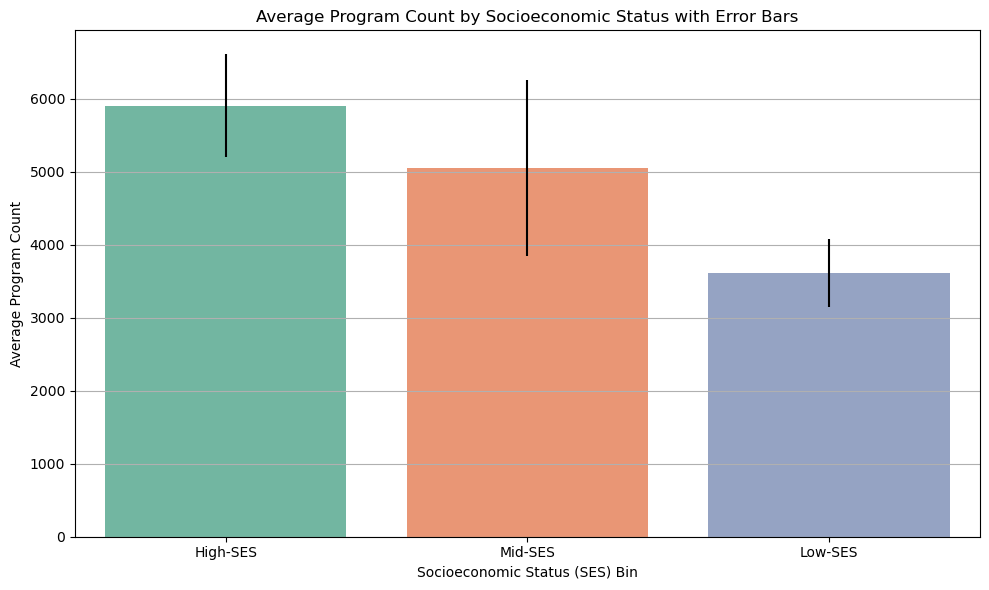

In [ ]:
#| echo: false
# Plotting the average program count by SES Bin with optional error bars
plt.figure(figsize=(10, 6))
sns.barplot(
    data=average_program_count_ses,
    x='ses_bin',
    y='Hardship Program Count',
    order=['High-SES', 'Mid-SES', 'Low-SES'],
    palette='Set2',
    yerr=average_program_count_ses['sem']  # Adding custom error bars representing SEM
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Average Program Count')
plt.title('Average Program Count by Socioeconomic Status with Error Bars')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

When examining the bar plot, high-SES areas have the most programs, while Low-SES areas have the fewest. This furthers the previous observation that lower socioeconomic areas have fewer in-person opportunities compared to higher socioeconomic areas, indicating a potential lack of resources in underserved communities.

We suggest that My Chi My Future allocates more resources to increase the number of in-person programs in Low-SES areas, focusing on outreach to ensure underprivileged communities are aware of the programs available. 

In addition to the overall count of programs offered to communities based on socioeconomic status, we analyzed the types of programs available by plotting Program Category against SES bins. 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


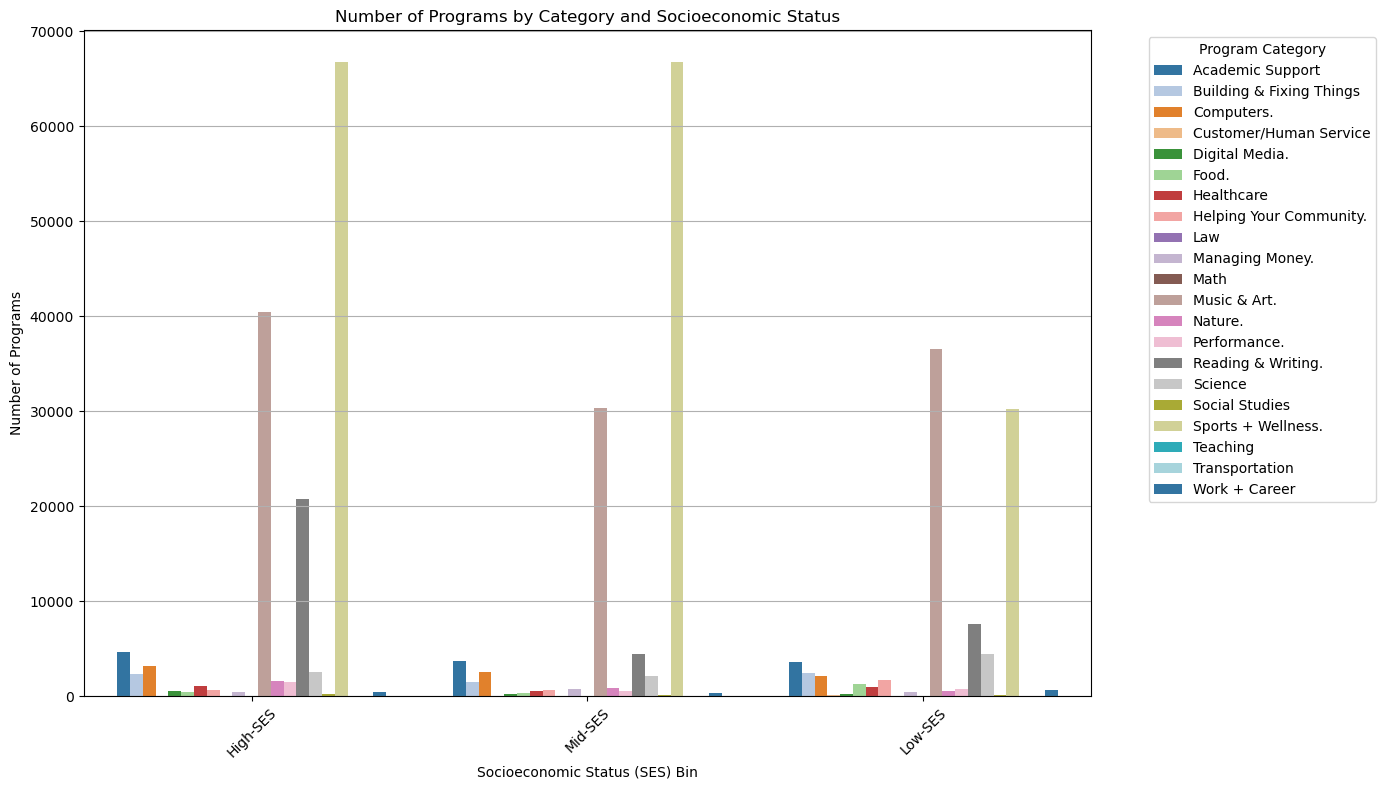

In [ ]:
#| echo: false
plt.figure(figsize=(14, 8))
sns.barplot(
    data=category_ses_counts,
    x='ses_bin',
    y='Program Count',
    hue='Category Name',
    palette=sns.color_palette('tab20', n_colors=len(category_ses_counts['Category Name'].unique()))
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs')
plt.title('Number of Programs by Category and Socioeconomic Status')
plt.xticks(rotation=45)
plt.legend(title='Program Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We noticed that Sports and Wellness programs dominate each SES category. However, Low-SES areas have significantly fewer Sports and Wellness programs compared to the higher SES areas. This discrepancy suggests potential inequalities in the types of opportunities available to different communities, especially in areas that may need them the most for well-being.


We also examined program acessibility by evaluating factors such as cost, availability of financial support(scholarships), whether participants were compensated, access to transportation services, and free food. We observed the affordability of programs by categorizing them by price, availability of financial support, paid participation, access to transportation services, and availability of free food and plotting the count by SES bins.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


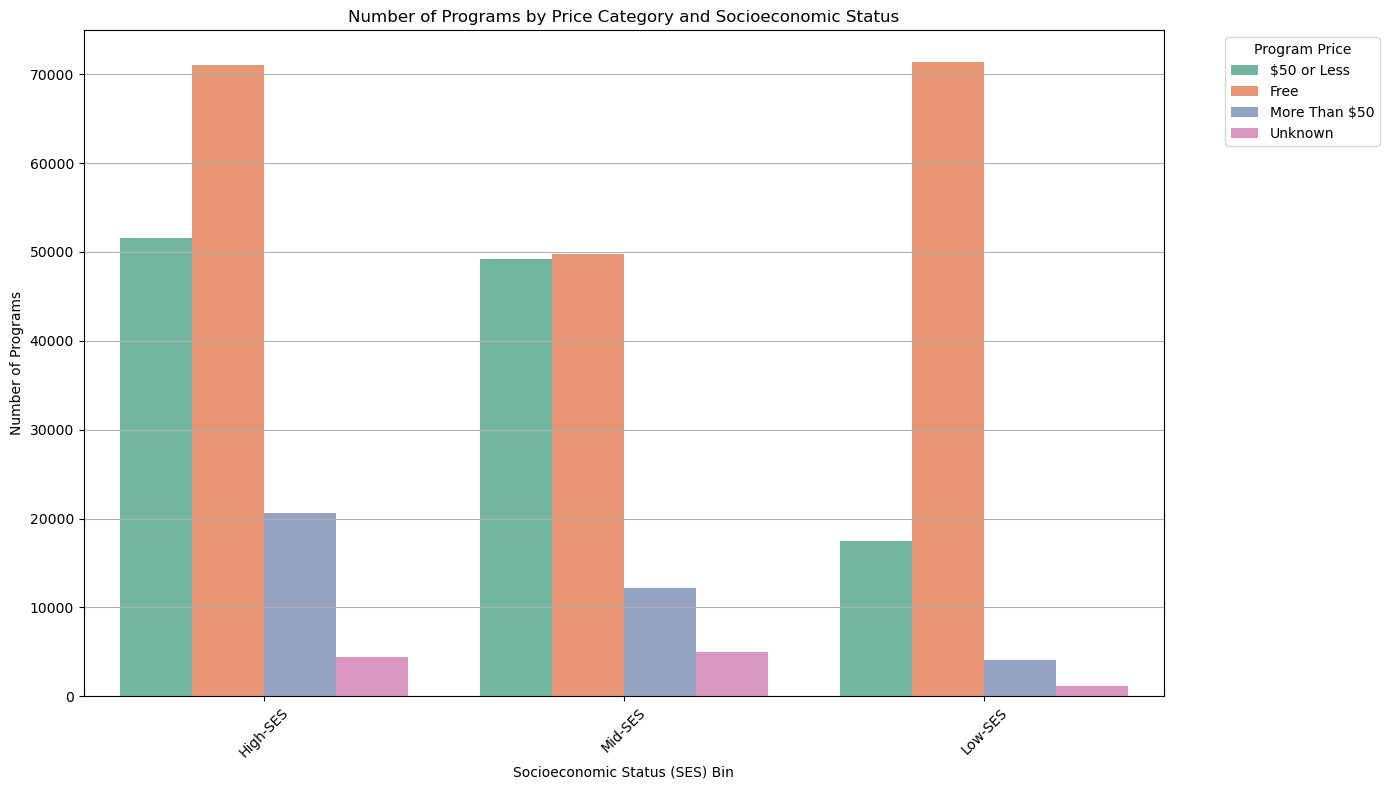

In [ ]:
#| echo: false
# Plotting the number of programs by price category and SES level
plt.figure(figsize=(14, 8))
sns.barplot(
    data=price_ses_counts,
    x='ses_bin',
    y='Count',
    hue='Program Price',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs')
plt.title('Number of Programs by Price Category and Socioeconomic Status')
plt.xticks(rotation=45)
plt.legend(title='Program Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


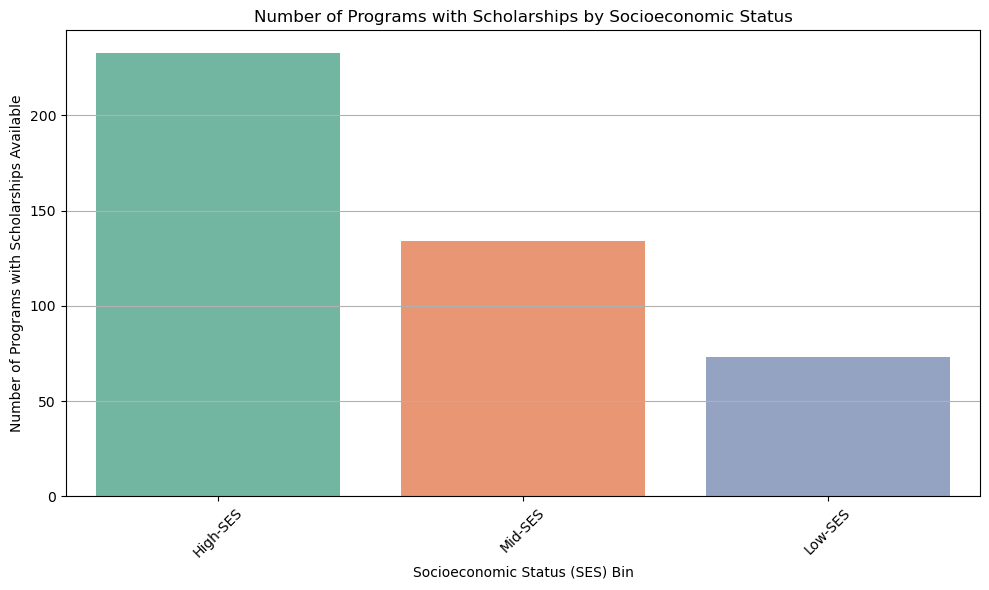

In [ ]:
#| echo: false
# Plotting the number of programs with scholarships available by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=scholarship_ses_counts,
    x='ses_bin',
    y='Scholarship Program Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Scholarships Available')
plt.title('Number of Programs with Scholarships by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


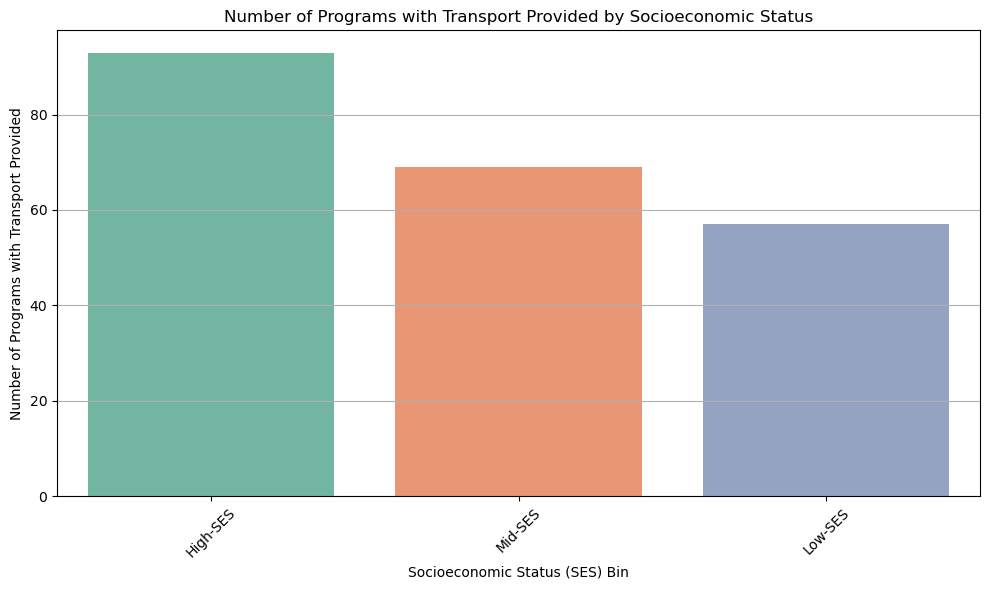

In [ ]:
#| echo: false
# Plotting the number of programs with transport provided by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=transport_ses_counts,
    x='ses_bin',
    y='Transport Provided Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Transport Provided')
plt.title('Number of Programs with Transport Provided by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


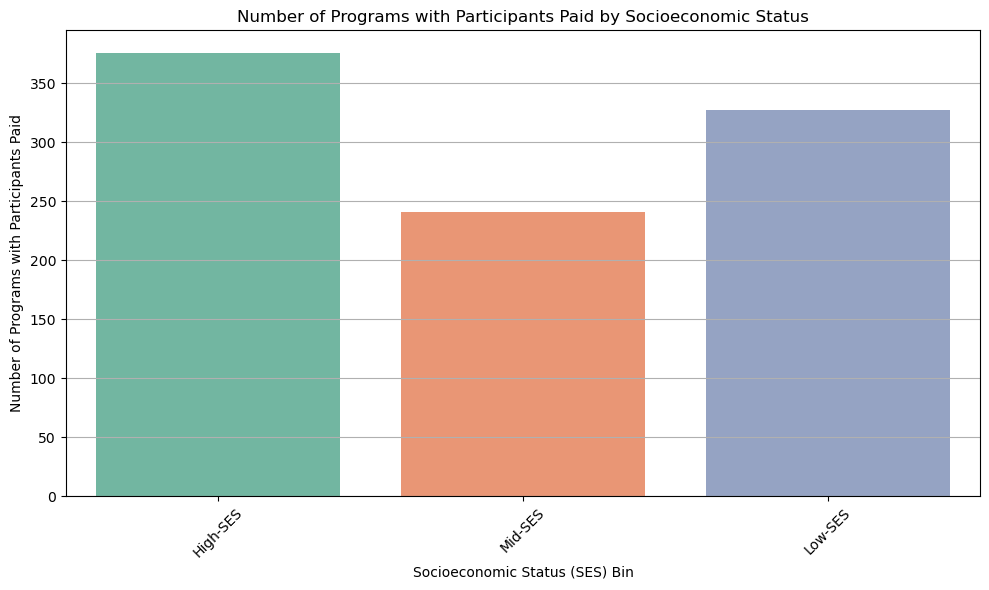

In [ ]:
#| echo: false
# Plotting the number of programs with participants paid by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=participants_paid_ses_counts,
    x='ses_bin',
    y='Participants Paid Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Participants Paid')
plt.title('Number of Programs with Participants Paid by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


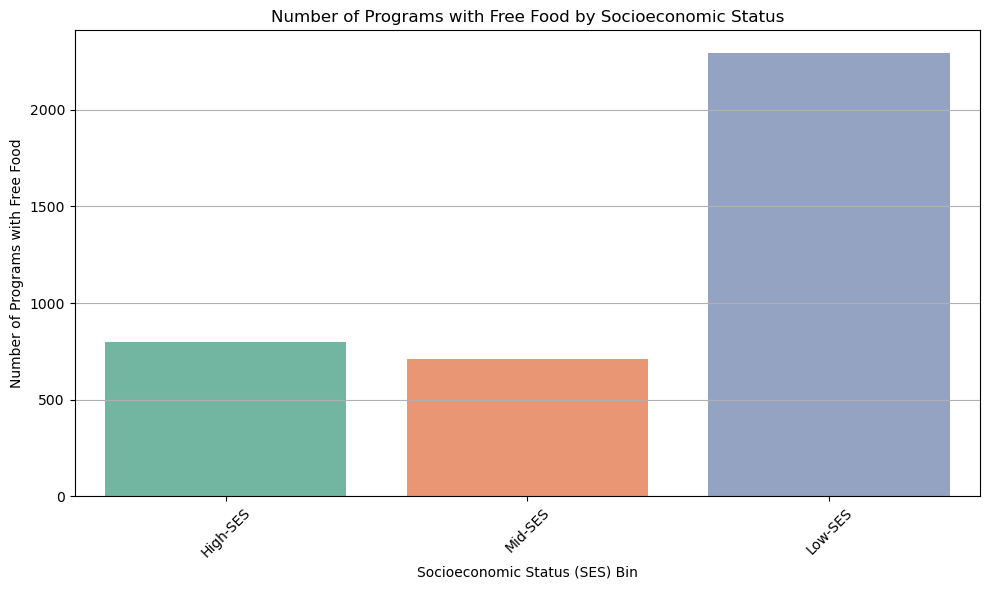

In [ ]:
#| echo: false
#Plotting the number of programs with free food by SES level
plt.figure(figsize=(10, 6))
sns.barplot(
    data=free_food_ses_counts,
    x='ses_bin',
    y='Free Food Count',
    palette='Set2'
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Number of Programs with Free Food')
plt.title('Number of Programs with Free Food by Socioeconomic Status')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The analysis of program accessibility across different socioeconomic status (SES) levels revealed several important trends and disparities. Free programs were found to be abundant in both Low-SES and High-SES neighborhoods, whereas Mid-SES neighborhoods had notably fewer free programs. This suggests a gap in accessibility for mid-level income communities, possibly indicating that these neighborhoods fall between eligibility for certain assistance programs while not having enough disposable income to afford other options. Regarding programs with scholarships and transportation support, High-SES areas had the most available, followed by Mid-SES and then Low-SES neighborhoods. This disparity suggests that Low-SES neighborhoods, which would benefit most from such support, are underserved, revealing a critical inequity in the distribution of program benefits.

Further analysis showed that programs where participants are paid were most common in High-SES areas, with Low-SES areas also having a reasonable number of such programs, whereas Mid-SES neighborhoods had the lowest number. This indicates that Mid-SES areas are lacking in paid program opportunities, highlighting a gap in incentivized participation in these communities. Additionally, the analysis of programs with free food showed the highest availability in Low-SES neighborhoods, suggesting targeted efforts to address food insecurity in areas most in need. However, both Mid-SES and High-SES areas had significantly fewer programs with free food, suggesting that the broader issue of food insecurity across all SES levels may not be adequately addressed.

## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

Overall, we found there is a smaller amount of programs in neighborhoods of lower socioeconomic status. Furthermore, Low-SES neighborhoods generally have more access to free programs and food support, but they are underrepresented in terms of transportation assistance and scholarship availability, both of which are crucial for increasing participation. Mid-SES areas are particularly underserved, with notably fewer free programs, scholarships, and paid opportunities compared to other SES groups. These communities often find themselves caught in a gap, not receiving targeted support despite facing economic barriers. In contrast, High-SES areas have the greatest access to scholarships, transportation, and paid opportunities, which indicates a misalignment in resource distribution—favoring areas that are less economically vulnerable. These disparities point to inequitable access to resources that can hinder community engagement and growth, particularly in Low-SES and Mid-SES neighborhoods.



## Recommendations to stakeholder(s)
What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable? 


To address disparities in program accessibility, we recommend targeted investments in communities with a high Hardship Index by introducing more programs and ensuring local government support, including mobile initiatives such as pop-up events and community outreach to reach those in the hardest-hit areas. Partnerships with NGOs and community-based organizations can also help bridge gaps in service delivery by bringing programs directly to these high-hardship communities. Expanding Sports and Wellness programs in Low-SES areas would also be beneficial, as these programs promote both physical and mental well-being. It is equally important to diversify program offerings in Low-SES neighborhoods, ensuring that residents have access to arts, educational, and skill-building programs that contribute to holistic development. We further suggest allocating more resources to increase the number of in-person programs in Low-SES areas, with a focus on outreach to make sure underprivileged communities are aware of available opportunities. Mid-SES neighborhoods would also benefit from increased availability of free programs, as well as greater access to scholarships and paid opportunities. These communities often fall into a gap—where they are not poor enough to qualify for targeted assistance but not affluent enough to afford available resources. To address these gaps, Low-SES neighborhoods need increased transportation support and needs-based scholarships. While these neighborhoods benefit from free food programs, a lack of transport assistance remains a significant barrier to participation. A more equitable redistribution of resources, such as scholarships and transportation support, across communities could help bridge these disparities. Finally, implementing community outreach initiatives to raise awareness about scholarships, transportation, and paid opportunities would be beneficial, especially for Low-SES and Mid-SES neighborhoods, where lack of awareness might be contributing to reduced participation.

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Authors. The frobnicatable foo filter, 2014. Face and Gesture submission ID 324. Supplied as additional material
fg324.pdf. 3
